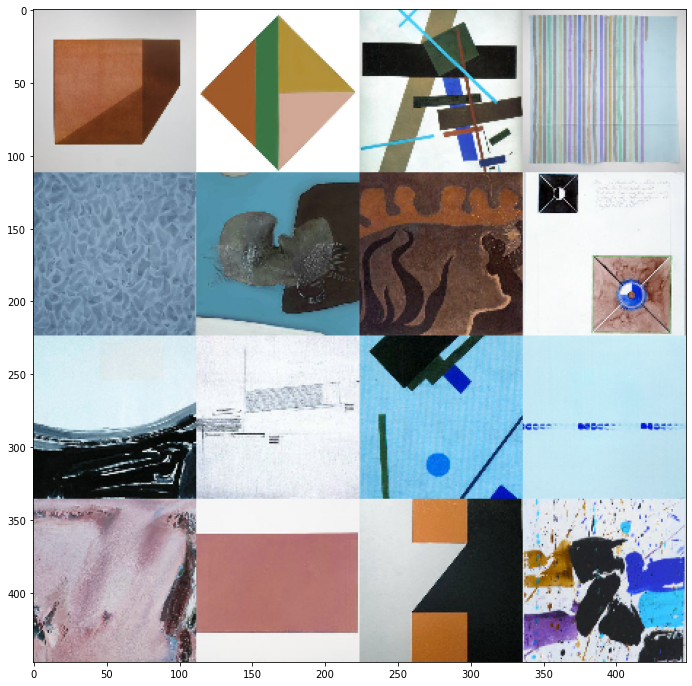

In [1]:
import glob
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
from matplotlib.pyplot import figure


class AbstractArtDataset:
    # Source: https://www.kaggle.com/greg115/abstract-art
    def __init__(self, path, size=112):
        self.size = size
        self.path = path
        self.images = []
        self.artists = []

    def visualise(self, inx=0, size=4):
        grid = np.array(self.images[inx:inx + (size * size)])
        index, height, width, intensity = grid.shape
        grid = (
            grid.reshape(size, size, self.size, self.size, intensity)
                .swapaxes(1, 2)
                .reshape(self.size * size, self.size * size, intensity)
        )
        figure(figsize=(12, 12))
        plt.imshow(grid)
        plt.show()

    def load(self):
        for path in list(glob.glob(self.path + "/*"))[:20]:
            _, artist, _ = os.path.basename(path).split("_")
            img = cv2.imread(path, 1)
            img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_LINEAR)
            self.images.append(img)
            self.artists.append(artist)


art = AbstractArtDataset("/Users/Alexey.Shapovalov@ig.com/Projects/nuig/deeplearning/abstract_art_512")
art.load()
art.visualise()

Number of examples: 60000
Shape of the images in the dataset: (28, 28)


2022-03-20 14:06:44.865882: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/2
1/1 [==============================] - ETA: 0s - loss: 807.8494 - kl_loss: 3.5810e-04 - mse_loss: 807.8491

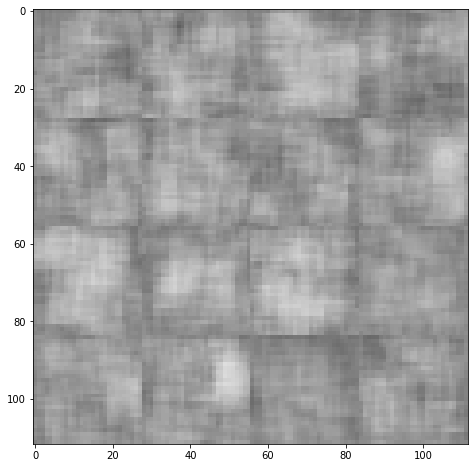

1/1 [==============================] - 1s 1s/step - loss: 807.8494 - kl_loss: 3.5810e-04 - mse_loss: 807.8491
Epoch 2/2
1/1 [==============================] - ETA: 0s - loss: 731.2652 - kl_loss: 0.0017 - mse_loss: 731.2634

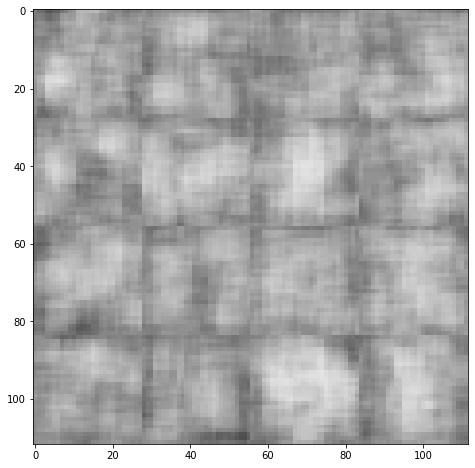

1/1 [==============================] - 0s 233ms/step - loss: 731.2652 - kl_loss: 0.0017 - mse_loss: 731.2634


In [2]:
from generator import generative_model
from monitor import ModelMonitor
from keras.api import keras
from vae import get_vae
from wgan import WGAN
import tensorflow as tf


IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 1024
BUFFER_SIZE = 2048
LATENT_SIZE = 128
EPOCHS = 2
VAE_PATH = './vae'
WGAN_PATH = './wgan'


fashion_mnist = keras.datasets.fashion_mnist
(train_images, _), (test_images, _) = fashion_mnist.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

# Reshape each sample to (28, 28, 1) and normalize the pixel values in the [-1, 1] range
train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
dataset = tf.data.Dataset.from_tensor_slices((train_images - 127.5) / 127.5)
dataset = dataset.take(10).shuffle(buffer_size=2048).batch(BATCH_SIZE)


# VAE Method =================================================================
generator = generative_model(IMG_SHAPE, LATENT_SIZE)
vae_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae, encoder = get_vae(IMG_SHAPE, LATENT_SIZE, generator)
vae.compile(vae_optimizer)
callback = ModelMonitor(generator, IMG_SHAPE, LATENT_SIZE, VAE_PATH, 4)
# vae.summary()
vae.fit(dataset, callbacks=[callback], epochs=EPOCHS)

In [ ]:
# WGAN Method =================================================================
train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
dataset = tf.data.Dataset.from_tensor_slices((train_images - 127.5) / 127.5)
dataset = dataset.shuffle(buffer_size=BUFFER_SIZE)

generator = generative_model(IMG_SHAPE, LATENT_SIZE)
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
wgan = WGAN(
    img_shape=IMG_SHAPE,
    latent_size=LATENT_SIZE,
    generator=generator,
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=generator_optimizer,
)
wgan.compile()
callback = ModelMonitor(generator, IMG_SHAPE, LATENT_SIZE, WGAN_PATH, 4)
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[callback])

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 zero_padding2d_2 (ZeroPaddi  (None, 32, 32, 1)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 64)        1664      
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                     

In [ ]:
import numpy as np
from keras.api import keras
import tensorflow as tf
from matplotlib import pyplot as plt
import os


class ModelMonitor(keras.callbacks.Callback):
    def __init__(self, generator, img_shape, latent_size, path, size):
        super().__init__()
        self.size = size
        self.model = generator
        self.img_shape = img_shape
        self.latent_size = latent_size
        self.path = path
        os.makedirs(path, exist_ok=True)
        os.makedirs(path + '/epochs', exist_ok=True)
        os.makedirs(path + '/checkpoints', exist_ok=True)

    def on_epoch_end(self, epoch, **kwargs):
        random_latent_vectors = tf.random.normal(shape=(self.size * self.size, self.latent_size))
        generated_images = self.model(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5
        grid = np.array(generated_images)
        grid = (
            grid.reshape(self.size, self.size, self.img_shape[0], self.img_shape[0])
                .swapaxes(1, 2)
                .reshape(self.img_shape[0] * self.size, self.img_shape[0] * self.size)
        )
        plt.figure(figsize=(8, 8))
        plt.imsave('{}/epochs/{}.png'.format(self.path, epoch), grid, cmap='gray', vmin=0, vmax=255)
        plt.imshow(grid, cmap='gray', vmin=0, vmax=255)
        plt.show()


monitor = ModelMonitor(generator, IMG_SHAPE, LATENT_SIZE, VAE_PATH, 10)
monitor.on_epoch_end(1)